# Fully connected Deep Neural Network

We now present the implementation of a fully connected Deep Neural Network that identifies classes from the ASL (American Sign Language) dataset.

We will divide this in 2 parts:
1. The preparation of the data
2. The implementation of the model

## 1. Data preparation

### Imports

In [85]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

### Data Exploration




In [86]:
# Lets load the data
DATA_PATH = '.'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))
print(f"shape of train_df: {train_df.shape}")
print(f"shape of valid_df: {valid_df.shape}")
print(f"number of classes: {valid_df.label.nunique()}")
# Get min and max pixel values
pixel_max = max(train_df.iloc[:, 1:].max().max(), valid_df.iloc[:, 1:].max().max())
pixel_min = min(train_df.iloc[:, 1:].min().min(), valid_df.iloc[:, 1:].min().min())
print(f"Pixel value range: min = {pixel_min}, max = {pixel_max}")

train_df.head()

shape of train_df: (27455, 785)
shape of valid_df: (7172, 785)
number of classes: 24
Pixel value range: min = 0, max = 255


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


#### Utility functions for the data preprocessing stage

In this section we will build some utility functions that will help us with some specific tasks, such as:
- data splits 
- data normalization
- data visualization



In [87]:

#### ---------- Utility functions ----------
def get_asl_alphabet():
    """
    Returns a list of lowercase letters excluding 'j' and 'z' which are used in ASL.
    The ASL dataset excludes 'j' and 'z' because they require motion and cannot be represented in static images.
    In order to identify our 24 classes we will need to match the selected 24 letters with the 24 classes in our dataset.
    
    Returns:
        list: List of 24 lowercase letters used in static ASL hand positions
    """
    alphabet = list(string.ascii_lowercase)
    alphabet.remove('j')  # The letter 'j' in ASL requires motion
    alphabet.remove('z')  # The letter 'z' in ASL requires motion
    return alphabet

### ---------- Data splitting functions ----------
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Split data into validation and test sets.
    
    Args:
        x (np.ndarray): Input features
        y (np.ndarray): Labels
        pct (float): Percentage of data to use for validation (default: 0.5)
        shuffle (bool): Whether to shuffle the data before splitting (default: True)
    
    Returns:
        tuple: (x_val, y_val, x_test, y_test)
    '''
    n_samples = len(x)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    split_idx = int(n_samples * pct)
    val_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    return x[val_indices], y[val_indices], x[test_indices], y[test_indices]

#### ---------- Normalization functions ----------
def normalize_data(x_train, x_val, x_test):
    """
    Normalize image data to [0,1] range by dividing by 255.
    
    Args:
        x_train (np.ndarray): Training data
        x_val (np.ndarray): Validation data
        x_test (np.ndarray): Test data
        
    Returns:
        tuple: Normalized (x_train, x_val, x_test)
    """
    # Normalize to [0,1] range
    x_train_norm = x_train / 255.0
    x_val_norm = x_val / 255.0
    x_test_norm = x_test / 255.0
    
    return x_train_norm, x_val_norm, x_test_norm

### ---------- Minibatch generator ----------
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Creates mini-batches from input data for training neural networks.
    Discussion:

    "Mini-batch gradient descent can be understood as applying full batch gradient descent 
    to smaller subsets of the training data, for example, 32 training examples at a time. 
    The advantage over full batch gradient descent is that convergence is reached faster 
    via mini-batches because of the more frequent weight updates."
    ![Machine Learning with PyTorch and Scikit-Learn](https://learning.oreilly.com/library/view/machine-learning-with/9781801819312/Text/Chapter_2.xhtml#_idParaDest-48)
    Args:
        mb_size (int): Size of each mini-batch
        x (np.ndarray): Input features array of shape (n_samples, 784)
        y (np.ndarray): Target labels array of shape (n_samples, 1)
        shuffle (bool, optional): Whether to shuffle the data before creating mini-batches. 
                                Defaults to True.
    
    Returns:
        generator: Generator yielding tuples of (x_batch, y_batch), where each batch
                 has shape (mb_size, 784) for x_batch and (mb_size, 1) for y_batch
    
    Raises:
        AssertionError: If the number of samples in x and y don't match
    
    Example:
        >>> x_data = np.random.rand(1000, 784)
        >>> y_data = np.random.rand(1000, 1)
        >>> batches = create_minibatches(32, x_data, y_data)
        >>> for x_batch, y_batch in batches:
        ...     # Process each batch
        ...     pass
    """    
    assert x.shape[0] == y.shape[0], 'Error: number of samples in x and y must match'
    total_data = x.shape[0]
    
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    
    minibatch = ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))
    return minibatch

#### ---------- Data visualization functions ----------
def plot_sign(image, label=None, predicted=None):
    """
    Plot a single ASL sign image with optional label information.
    
    Args:
        image (np.ndarray): Image data in shape (784,) or (28,28)
        label (int, optional): True label index
        predicted (int, optional): Predicted label index
    """
    # Reshape if the image is flattened
    if image.shape != (28, 28):
        image = image.reshape(28, 28)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Add title with label information if provided
    if label is not None and predicted is not None:
        title = f'True: {get_asl_alphabet()[label]}'
        if predicted is not None:
            title += f' | Predicted: {get_asl_alphabet()[predicted]}'
        plt.title(title)
    
    plt.show()

def plot_sample_signs(x_data, y_data, num_samples=5):
    """
    Plot multiple random samples from the dataset.
    
    Args:
        x_data (np.ndarray): Image data
        y_data (np.ndarray): Labels
        num_samples (int): Number of samples to plot
    """
    plt.figure(figsize=(15, 3))
    
    for i in range(num_samples):
        idx = np.random.randint(len(y_data))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {get_asl_alphabet()[y_data[idx]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


### Data processing

Now with all our utilities in place, we can proceed to prepare our data in a format that our model can work with.
1. Separate our features from our target variables 
2. Our data is made of integers, we will convert them to floats.
3. We will divide our data into training, validation and test dataframes
4. Then we will proceed with the normalization.
5. And finally we will inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.



x_train_norm.shape: (27455, 784)
x_val_norm.shape: (3586, 784)
x_test_norm.shape: (3586, 784)


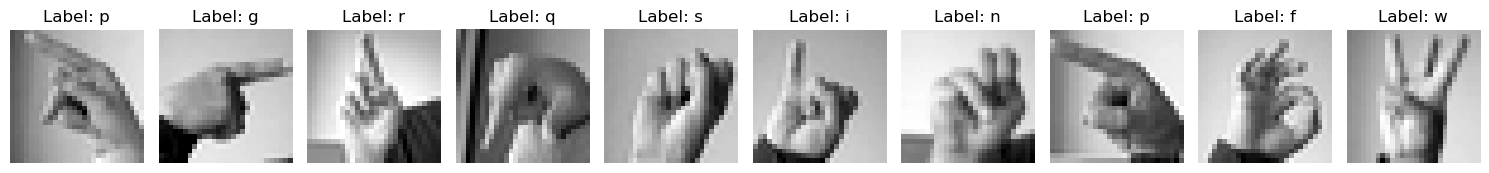

In [88]:
# 1. separate our features from our target variables 
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
# And remove it from our train_df and valid_df dataframes
del train_df['label']
del valid_df['label']

# 2.Cast to float32
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

# 3. Split data into training, validation and test sets
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

# 4. Normalize data
x_train_norm, x_val_norm, x_test_norm = normalize_data(x_train, x_val, x_test)

# 5. Inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.
print(f"x_train_norm.shape: {x_train_norm.shape}")
print(f"x_val_norm.shape: {x_val_norm.shape}")
print(f"x_test_norm.shape: {x_test_norm.shape}")
# Plot 10 random samples from validation data
plot_sample_signs(x_train, y_train, num_samples=10)

# Model implementation



## Linear Layer


In [89]:

def softmaxXEntropy(x, y):

    batch_size = x.shape[1]
    
    # Forward pass
    exp_scores = np.exp(x)  # Compute exponentials
    probs = exp_scores / exp_scores.sum(axis=0)  # Normalize to get probabilities
    preds = probs.copy()  # Store predictions
    
    # Compute cross-entropy loss
    y_hat = probs[y.squeeze(), np.arange(batch_size)]  # Get probabilities of correct classes
    cost = np.sum(-np.log(y_hat)) / batch_size  # Average negative log likelihood
    
    # Backward pass - compute gradients
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # Derivative of softmax+cross-entropy
    x.grad = probs.copy()  # Store gradients for backprop
    
    
    return preds, cost


class np_tensor(np.ndarray): pass

# Linear Layer

class Linear():
    
    def __init__(self, input_size, output_size):
        
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
        
    def __call__(self, X):
       
        Z = self.W @ X + self.b
        return Z
        
    def backward(self, X, Z):
        
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)


# ReLU Layer
class ReLU():
    def __call__(self, Z):
        # [1] Forward pass: max(0,x) operation
        return np.maximum(0, Z)  # Element-wise comparison and selection
    
    def backward(self, Z, A):
        # [2] Initialize gradient computation with upstream gradients
        Z.grad = A.grad.copy()   # Copy to avoid modifying upstream gradients
        
        # [3] Apply ReLU gradient mask
        Z.grad[Z <= 0] = 0       # Gradient is 0 where input was <= 0

class Sequential_layers():
    """A sequential container for neural network layers."""
    
    def __init__(self, layers):
        """Initialize model with a list of layers."""
        # [1] Initialize container attributes
        self.layers = layers            # Store layer sequence
        self.x = None                   # Current input placeholder
        self.outputs = {}               # Cache for intermediate values
        
    def __call__(self, X):
        """Forward pass through all layers, returns output logits."""
        # [2] Start forward propagation sequence
        self.x = X 
        self.outputs['l0'] = self.x     # Store input as first output
        
        # [3] Iterate through layers sequentially
        for i, layer in enumerate(self.layers, 1):
            # [4] Process and store each layer's output
            self.x = layer(self.x)                  # Transform data
            self.outputs['l'+str(i)] = self.x       # Cache output
        return self.x
        
    def backward(self):
        """Backward pass to compute gradients for all layers."""
        # [5] Initialize backward pass
        for i in reversed(range(len(self.layers))):
            # [6] Backward propagation through each layer
            self.layers[i].backward(
                self.outputs['l'+str(i)],     # Input to current layer
                self.outputs['l'+str(i+1)]    # Output from current layer
            )
    
    def update(self, learning_rate=1e-3):
        """Update model parameters using computed gradients."""
        # [7] Parameter update loop
        for layer in self.layers:
            # [8] Skip ReLU layers (no parameters)
            if isinstance(layer, ReLU): continue
            
            # [9] Update weights and biases
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
            
    def predict(self, X):
        """Return predicted class indices for input data X."""
        # [10] Utility function to predict a batch of data
        scores = self.__call__(X)
        return np.argmax(scores, axis=0)


# Accuracy function
def accuracy(x, y, mb_size, model):
    """Calculate prediction accuracy across mini-batches."""
    correct = 0
    total = 0
    
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
        # Get model predictions
        logits = model(x_batch.T.view(np_tensor))
        pred = np.argmax(logits, axis=0)
        
        # Compare predictions with labels
        correct += np.sum(pred == y_batch.squeeze())
        
        # Update total count using batch size
        total += len(pred)
    
    return correct/total


# Training loop
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    #print(f"mb_size: {mb_size}")
    # print(f"x_train_norm.shape: {x_train_norm.shape}")

    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train_norm, y_train)):            
            
            scores = model(x.T.view(np_tensor))
            #print(f"scores shape: {scores.shape}")
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)            
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size, model)}')
        costs.append(cost)
        accuracies.append(accuracy(x_val, y_val, mb_size, model))

In [90]:
def plot_training_progress(costs, accuracies):
    """
    Plot training costs and validation accuracies over epochs.
    
    Args:
        costs (list): List of training costs per epoch
        accuracies (list): List of validation accuracies per epoch
    """
    epochs = range(1, len(costs) + 1)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training cost
    ax1.plot(epochs, costs, 'b-', label='Training Cost')
    ax1.set_title('Training Cost over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Cost')
    ax1.grid(True)
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f'Final training cost: {costs[-1]:.4f}')
    print(f'Final validation accuracy: {accuracies[-1]:.4f}')

### Create your model and train it

costo: 2.765220966627578, accuracy: 0.22392638036809817
costo: 2.480202278063628, accuracy: 0.3845510317902956
costo: 2.1698114388563843, accuracy: 0.41494701617401003
costo: 1.901690457888438, accuracy: 0.456776352481874
costo: 1.889790511851802, accuracy: 0.482989403234802
costo: 1.6173340003104355, accuracy: 0.5298382598996096
costo: 1.4997481195133993, accuracy: 0.5164528722810932
costo: 1.3900024995086906, accuracy: 0.5702732849972114
costo: 1.4363311149989997, accuracy: 0.5373675404350251
costo: 1.2819533086394774, accuracy: 0.571946458449526
costo: 1.1954662110210768, accuracy: 0.5658114891243725
costo: 1.189957963993762, accuracy: 0.5881204684885667
costo: 1.1149474829460568, accuracy: 0.6229782487451199
costo: 0.940025591771478, accuracy: 0.6182375906302287
costo: 0.9917501624559697, accuracy: 0.6366424986056888
costo: 0.993342223492649, accuracy: 0.6352481873954267
costo: 1.0452110708300952, accuracy: 0.6360847741215839
costo: 1.0926598089614188, accuracy: 0.6475181260457334


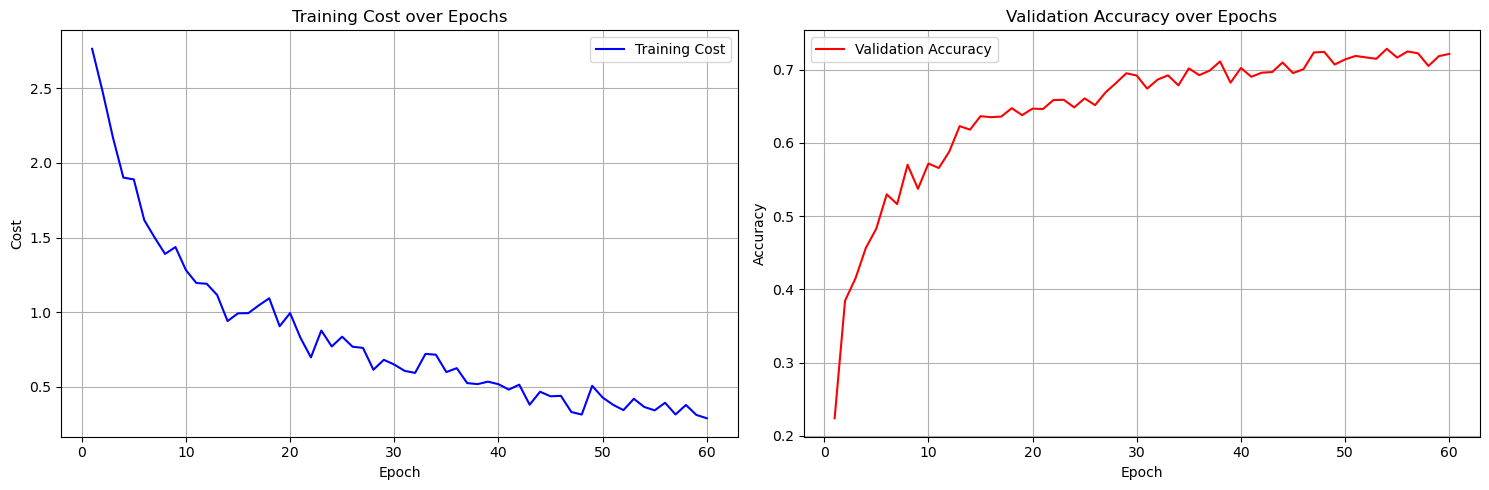

Final training cost: 0.2885
Final validation accuracy: 0.7217


In [91]:

mb_size = 512
learning_rate = 1e-4
epochs = 60

# Model definition
model = Sequential_layers([
    Linear(784, 200), 
    ReLU(), 
    Linear(200, 24)]
)

costs = []
accuracies = []

train(model, epochs, mb_size, learning_rate)
# Plot training progress after training
plot_training_progress(costs, accuracies)

costo: 2.676516355393167, accuracy: 0.3181818181818182
costo: 2.255793500688626, accuracy: 0.43112102621305076
costo: 2.0388141605061105, accuracy: 0.4436698271054099
costo: 1.7780084950678834, accuracy: 0.4762967094255438
costo: 1.9788512620081595, accuracy: 0.4986056887897379
costo: 1.7846720848637083, accuracy: 0.5368098159509203
costo: 1.6591577224617948, accuracy: 0.5217512548800892
costo: 1.2646586306523786, accuracy: 0.5867261572783046
costo: 1.1216865442085289, accuracy: 0.568042387060792
costo: 1.156323296768246, accuracy: 0.6213050752928053
costo: 0.9734280798455176, accuracy: 0.6048522030117122
costo: 0.8494713992525216, accuracy: 0.6561628555493586
costo: 0.724777162901554, accuracy: 0.6823759063022866
costo: 0.8340479092846724, accuracy: 0.6622978248745119
costo: 1.0187963688577446, accuracy: 0.6385945343000557
costo: 0.6044609126282552, accuracy: 0.7138873396542108
costo: 0.6487164728972681, accuracy: 0.7228109313998885
costo: 0.6305176666677811, accuracy: 0.7214166201896

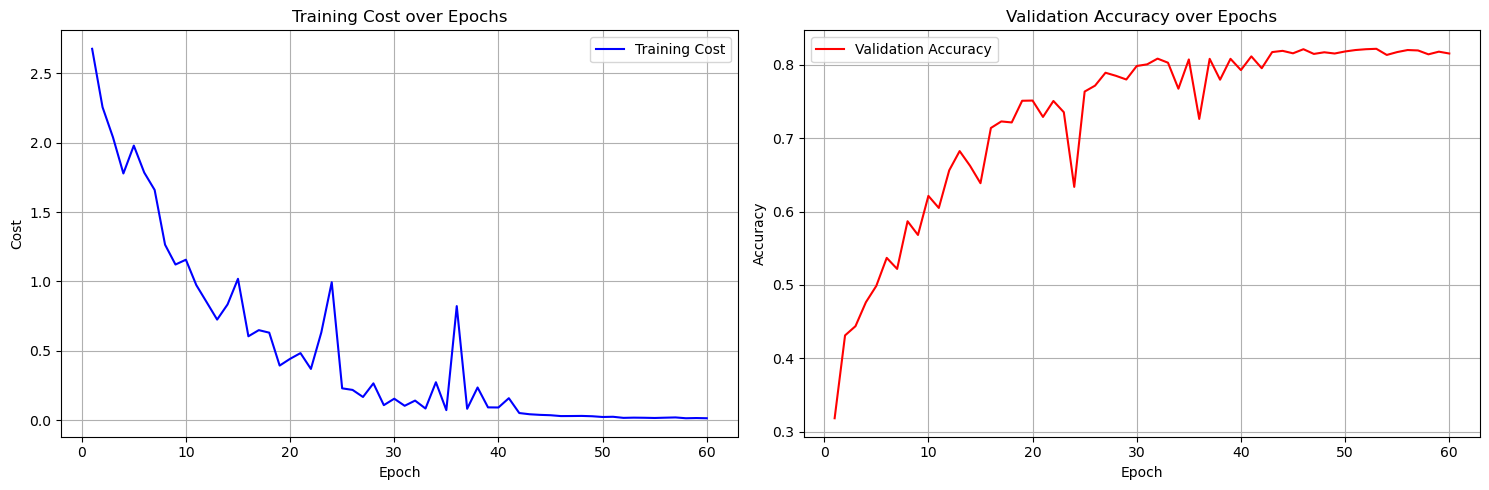

Final training cost: 0.0137
Final validation accuracy: 0.8154


In [94]:

mb_size = 512
learning_rate = 1e-4
epochs = 60

# Model definition

model2 = Sequential_layers([
    Linear(784, 400), 
    ReLU(), 
    Linear(400, 400), 
    ReLU(), 
    Linear(400, 400), 
    ReLU(), 
    Linear(400, 24)]    
)
costs = []
accuracies = []

train(model2, epochs, mb_size, learning_rate)
# Plot training progress after training
plot_training_progress(costs, accuracies)

costo: 2.468150766779776, accuracy: 0.3042387060791969
costo: 2.086474380784419, accuracy: 0.4617958728388176
costo: 2.416759594482536, accuracy: 0.39040713887339656
costo: 2.3574948750430136, accuracy: 0.369771332961517
costo: 1.5843240537582417, accuracy: 0.44506413831567204
costo: 1.3948420425848118, accuracy: 0.5633017289459007
costo: 1.539805902506879, accuracy: 0.564138315672058
costo: 1.2428506690878542, accuracy: 0.6291132180702733
costo: 1.411509617361461, accuracy: 0.5368098159509203
costo: 0.7046195596929612, accuracy: 0.6589514779698828
costo: 1.052786490018016, accuracy: 0.6450083658672616
costo: 0.7523595767622189, accuracy: 0.6999442275515895
costo: 0.5476175154873505, accuracy: 0.72643614054657
costo: 0.35495882640413495, accuracy: 0.7504182933630786
costo: 0.5540239844068133, accuracy: 0.7403792526491912
costo: 0.42352445463602945, accuracy: 0.7573898494143892
costo: 1.5578164007071114, accuracy: 0.5546569994422755
costo: 0.275629277356503, accuracy: 0.7816508644729504

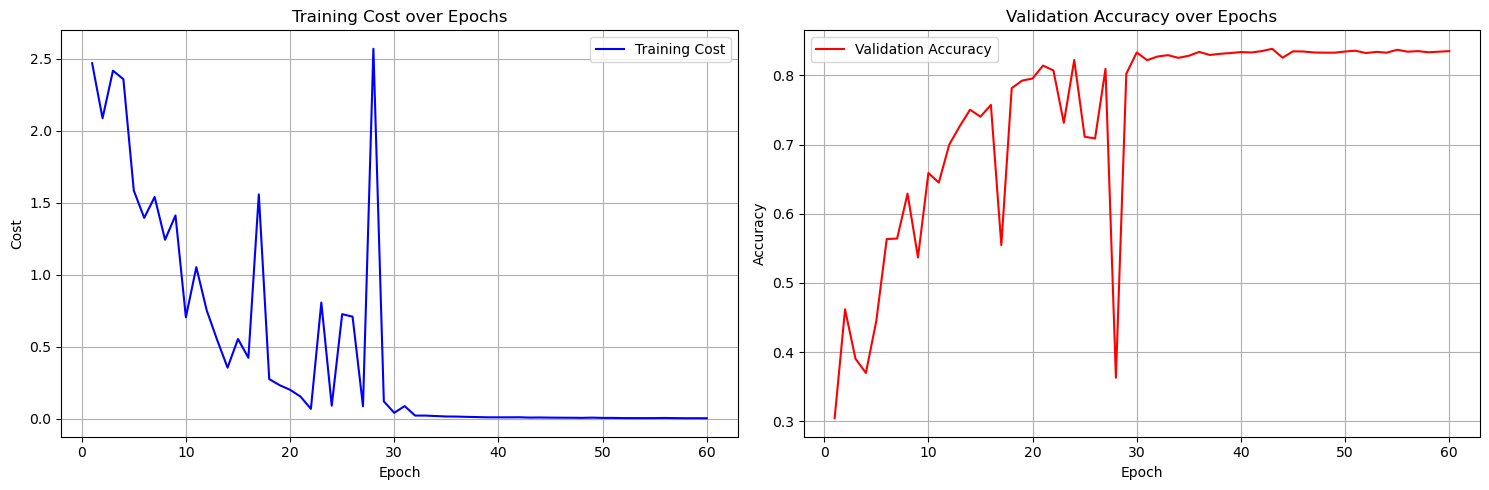

Final training cost: 0.0037
Final validation accuracy: 0.8352


In [98]:

mb_size = 512
learning_rate = 1e-4
epochs = 60

# Model definition

model3 = Sequential_layers([
    Linear(784, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 24)]    
)
costs = []
accuracies = []

train(model3, epochs, mb_size, learning_rate)
# Plot training progress after training
plot_training_progress(costs, accuracies)

Test set accuracy: 0.8318


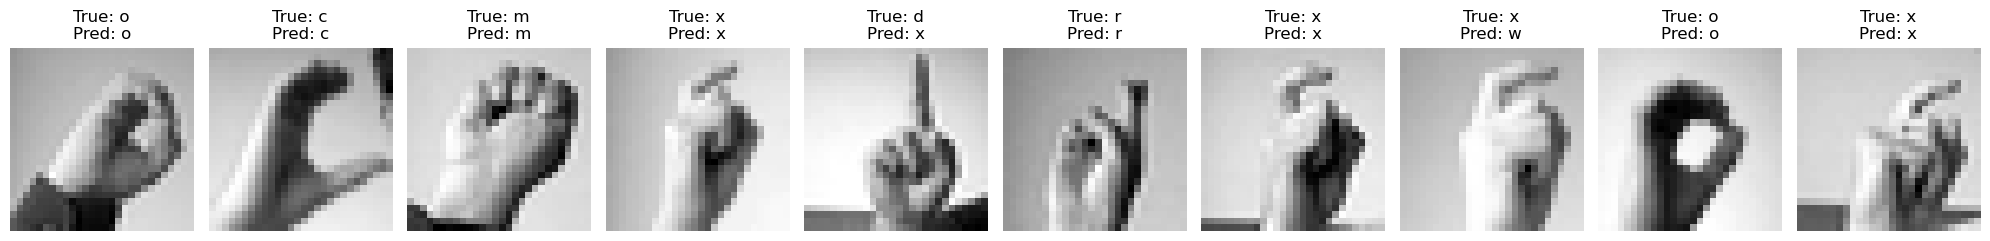

In [100]:
# Get test set accuracy
test_accuracy = accuracy(x_test_norm, y_test, mb_size, model3)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Let's visualize some predictions
plt.figure(figsize=(20, 4))
test_batch_x, test_batch_y = next(create_minibatches(10, x_test_norm, y_test))
predictions = model3.predict(test_batch_x.T.view(np_tensor))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_batch_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {get_asl_alphabet()[test_batch_y[i]]}\nPred: {get_asl_alphabet()[predictions[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()